In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Exploring the adult data set from the UCI repository.
# Download the files adult.data and adult.test
# from https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import adult
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from forest_clusters import ForestClusters, buckets, total_variation
from display_cluster import display_cluster, CompressedForest
from category_encoders.one_hot import OneHotEncoder as CEOneHotEncoder

# First, let's import the adult data set and clean it up

original = adult.original
categorical = [col for col in original.columns 
               if not np.issubdtype(original[col].dtype, np.number)]
original[categorical] = original[categorical].fillna(value = 'None')
# Make sex a boolean feature
original = original.assign(male = original['sex'] == 'Male')
original = original[original.columns.difference(['sex'])]
                                                 
sanitized = original[original.columns.difference(['target'])]
# sanitized = sanitized.assign(Workclass = sanitized['Workclass'].replace(['Without-pay'], value='None'))
# sanitized = sanitized.assign(Relationship = sanitized['Relationship'].replace(['Husband', 'Wife'], value = 'Spouse'))
# sanitized = sanitized[sanitized.columns.difference(['Capital Gain', 'Capital Loss', 'Education-Num'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Marital Status', 'Relationship'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Occupation', 'Workclass', 'Hours per week'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Race', 'Male', 'Age'])] # Removing important features
# sanitized = sanitized[sanitized.columns.difference(['Country'])] # Removing important features
enc = CEOneHotEncoder(use_cat_names = True, handle_unknown =  'ignore').fit(sanitized)
                                                 
X = enc.transform(sanitized)
y = adult.labels

In [3]:
# Train a boosting model for binary classification.
# The model is a set of decision trees. Given a point, each tree
# outputs a score that counts towards the point's probability of
# belonging in the positive class.

original_train, original_test, X_train, X_test, y_train, y_test = train_test_split(original, X, y, train_size=0.9)

from xgboost import XGBClassifier

n_estimators = 1200

boost = XGBClassifier(n_estimators = n_estimators, max_depth = 2, min_samples_leaf = 100).fit(X_train, y_train)
print("Mean %f" % y.mean())
print("Train score %f" % boost.score(X_train, y_train))
print("Test score %f" % boost.score(X_test, y_test))

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Mean 0.239282
Train score 0.878199
Test score 0.870829


/home/arthur/env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/arthur/env/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


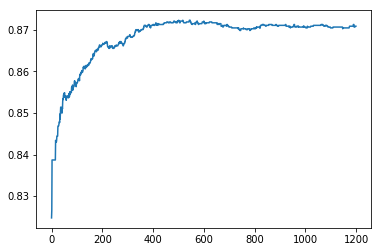

In [4]:
import warnings
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

scores = [(boost.predict(X_test, ntree_limit = k + 1) == y_test).mean()
          for k in range(n_estimators)]
plt.plot(range(n_estimators), scores)

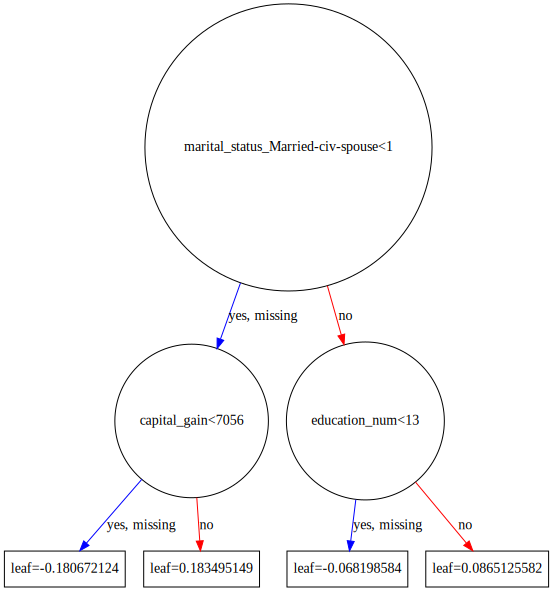

In [5]:
import xgboost
xgboost.to_graphviz(boost)

In [6]:
model = GradientBoostingClassifier(n_estimators = 6000, max_depth = 1).fit(X_train, y_train)
print("Train score", model.score(X_train, y_train))
print("Test score", model.score(X_test, y_test))

Train score 0.8726937689105262
Test score 0.8710337768679631


In [7]:
xgmodel = XGBClassifier(n_estimators = 6000, max_depth = 1).fit(X_train, y_train)
print("Train score", xgmodel.score(X_train, y_train))
print("Test score", xgmodel.score(X_test, y_test))

Train score 0.8728757649521123
Test score 0.8716479017400205


In [8]:
diffs = boost.predict(X) != xgmodel.predict(X)
diffs.mean()

0.019122886040702673

In [15]:
from xgboost import XGBRegressor
p1 = np.log(boost.predict_proba(X_train))[:,0]
p2 = np.log(xgmodel.predict_proba(X_train))[:,0]
print((p1 - p2).mean())

-0.029401544


In [25]:
xgbdiff = XGBRegressor(n_estimators = 100, max_depth = 2).fit(X_train, p1 - p2)

In [26]:
d = xgbdiff.predict(X_train)
print('Mean', np.abs((p1 - p2) - d).mean())

Mean 0.06200832


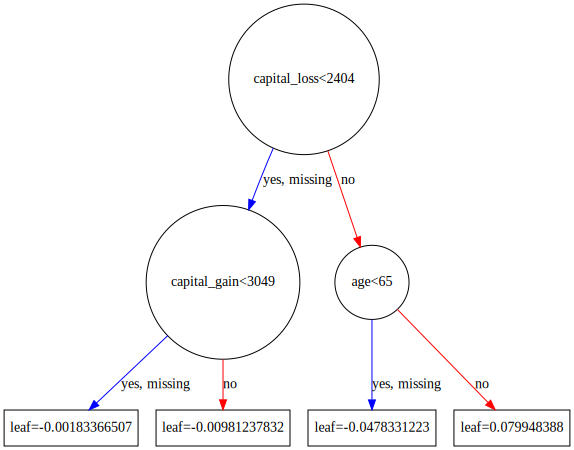

In [53]:
xgboost.to_graphviz(xgbdiff, num_trees = 29)

In [91]:
X_train, X_test, diffs_train, diffs_test = train_test_split(X, diffs)
diff_model = XGBClassifier(n_estimators = 3, max_depth = 2).fit(X_train, diffs_train)
print('Train', diff_model.score(X_train, diffs_train))
print('Test', diff_model.score(X_test, diffs_test))

Train 0.9819278752968796
Test 0.979199082794202


In [92]:
trees = [json.loads(t) for t in diff_model._Booster.get_dump(dump_format = 'json')]

In [93]:
trees

[{'children': [{'children': [{'leaf': -0.198694944, 'nodeid': 3},
     {'leaf': -0.143749997, 'nodeid': 4}],
    'depth': 1,
    'missing': 3,
    'no': 4,
    'nodeid': 1,
    'split': 'Education-Num',
    'split_condition': 15,
    'yes': 3},
   {'children': [{'leaf': -0.187874317, 'nodeid': 5},
     {'leaf': -0.139285728, 'nodeid': 6}],
    'depth': 1,
    'missing': 5,
    'no': 6,
    'nodeid': 2,
    'split': 'Occupation_Protective-serv',
    'split_condition': 1,
    'yes': 5}],
  'depth': 0,
  'missing': 1,
  'no': 2,
  'nodeid': 0,
  'split': 'Marital Status_Married-civ-spouse',
  'split_condition': 1,
  'yes': 1},
 {'children': [{'children': [{'leaf': -0.180665717, 'nodeid': 3},
     {'leaf': -0.13024123, 'nodeid': 4}],
    'depth': 1,
    'missing': 3,
    'no': 4,
    'nodeid': 1,
    'split': 'Education-Num',
    'split_condition': 15,
    'yes': 3},
   {'children': [{'leaf': -0.170643181, 'nodeid': 5},
     {'leaf': -0.126108006, 'nodeid': 6}],
    'depth': 1,
    'missin

In [89]:
import xgboost
xgboost.to_graphviz(diff_model._Booster, num_trees = 1)

ValueError: Unable to parse node: 0:[Marital

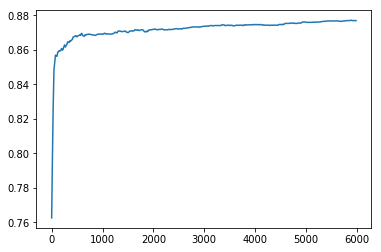

In [19]:
import warnings
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

scores = [(xgmodel.predict(X_test, ntree_limit = k + 1) == y_test).mean()
          for k in range(0, 6000, 15)]
plt.plot(range(0, 6000, 15), scores)

In [36]:
xgmodel._Booster.get_split_value_histogram('Capital Gain', bins = 6000)

,SplitValue,Count
0,3587.85,897.0
1,7117.70,1494.0
2,10647.55,353.0
3,21237.10,15.0
4,31826.65,66.0
5,70655.00,74.0


In [72]:
r = boost._Booster.get_dump(dump_format = 'json')[3]
import json
json.loads(r)

{'children': [{'children': [{'leaf': -0.140439466, 'nodeid': 3},
    {'leaf': 0.1437556, 'nodeid': 4}],
   'depth': 1,
   'missing': 3,
   'no': 4,
   'nodeid': 1,
   'split': 'Capital Gain',
   'split_condition': 7056,
   'yes': 3},
  {'children': [{'leaf': -0.0801230371, 'nodeid': 5},
    {'leaf': 0.0350235999, 'nodeid': 6}],
   'depth': 1,
   'missing': 5,
   'no': 6,
   'nodeid': 2,
   'split': 'Education-Num',
   'split_condition': 10,
   'yes': 5}],
 'depth': 0,
 'missing': 1,
 'no': 2,
 'nodeid': 0,
 'split': 'Marital Status_Married-civ-spouse',
 'split_condition': 1,
 'yes': 1}

In [64]:
from sklearn.linear_model import LogisticRegression
X2 = X[['Marital Status_Married-civ-spouse', 'Age', 'Capital Gain', 'Capital Loss', 'Education-Num']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, train_size = 0.9)
m = LogisticRegression(C = 1.5).fit(X2_train, y2_train)
print('Train', m.score(X2_train, y2_train))
print('Test', m.score(X2_test, y2_test))

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train 0.8435516527515526
Test 0.8356192425793245


In [65]:
import math
tests = {}

for e in model.estimators_[:,0]:
    feature = X.columns[e.tree_.feature[0]]
    threshold = e.tree_.threshold[0]
    if not feature in tests:
        tests[feature] = {}
    if not threshold in tests[feature]:
        tests[feature][threshold] = np.array([0.0, 0.0])
    tests[feature][threshold] += e.tree_.value[1:,0,0]
    
tests
tests_c = {feature: set(thresholds.keys())
           for feature, thresholds in tests.items()}
tests_c

{'Age': {23.5,
  24.5,
  25.5,
  26.5,
  27.5,
  28.5,
  29.5,
  30.5,
  33.5,
  35.5,
  36.5,
  38.5,
  42.5,
  43.5,
  44.5,
  45.5,
  46.5,
  53.5,
  54.5,
  59.5,
  61.5,
  66.5,
  72.5,
  73.5,
  85.5},
 'Capital Gain': {57.0,
  3048.0,
  3120.0,
  4243.5,
  4401.0,
  4668.5,
  4826.0,
  4973.5,
  5119.0,
  5316.5,
  6457.5,
  7055.5,
  7565.5,
  8296.0,
  10585.5,
  70654.5},
 'Capital Loss': {1457.0,
  1551.5,
  1568.5,
  1748.0,
  1820.5,
  1846.0,
  1859.0,
  1881.5,
  1894.5,
  1927.5,
  1975.5,
  1978.5,
  2168.5,
  2176.5,
  2218.5,
  2252.0,
  2262.5,
  2310.5,
  2384.5,
  2450.5,
  2469.5,
  2518.0,
  2581.0,
  2789.0,
  3089.5,
  3726.5},
 'Country_Cambodia': {0.5},
 'Country_Canada': {0.5},
 'Country_China': {0.5},
 'Country_Columbia': {0.5},
 'Country_Dominican-Republic': {0.5},
 'Country_Ecuador': {0.5},
 'Country_El-Salvador': {0.5},
 'Country_England': {0.5},
 'Country_France': {0.5},
 'Country_Greece': {0.5},
 'Country_Hong': {0.5},
 'Country_Hungary': {0.5},
 'Cou

In [73]:
def traverse_tree(tree, tests):
    feature = tree['split']
    threshold = tree['split_condition'] if 'split_condition' in tree else 1
    children = tree['children']
    thresholds = tests[feature] if feature in tests else set([])
    thresholds.add(threshold)
    tests[feature] = thresholds
    if 'children' in children[0]:
        tests = traverse_tree(children[0], tests)
    if 'children' in children[1]:
        tests = traverse_tree(children[1], tests)
    return tests

def boost_predicates(model):
    trees = [json.loads(t) for t in model._Booster.get_dump(dump_format = 'json')]
    tests = {}
    for tree in trees:
        tests = traverse_tree(tree, tests)
    return tests

boost_predicates(boost)

{'Age': {19,
  21,
  22,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  60,
  61,
  62,
  65,
  67,
  68,
  71,
  72,
  73,
  76,
  77,
  80,
  82,
  86,
  87},
 'Capital Gain': {58,
  3049,
  3121,
  4226,
  4244,
  4402,
  4669,
  4719,
  4827,
  4933,
  4974,
  5096,
  5120,
  5317,
  5910,
  6458,
  6619,
  7056,
  7074,
  7437,
  7566,
  8297,
  10544,
  10586,
  11142,
  12615,
  21046,
  30962,
  70655},
 'Capital Loss': {78,
  732,
  1447,
  1458,
  1495,
  1525,
  1538,
  1552,
  1569,
  1578,
  1749,
  1783,
  1806,
  1821,
  1847,
  1860,
  1882,
  1895,
  1928,
  1976,
  1979,
  2155,
  2169,
  2177,
  2191,
  2193,
  2219,
  2235,
  2253,
  2263,
  2311,
  2365,
  2366,
  2385,
  2425,
  2451,
  2470,
  2519,
  2582,
  2790,
  3090,
  3727},
 'Country_Cambodia': {1},
 'Country_Canada': {1},
 'Country_China': {1},
 'Country_Colum

In [66]:
estimators = [json.loads(t) for t in xgmodel._Booster.get_dump(dump_format = 'json')]
xgtests = {}
for e in estimators:
    feature = e['split']
    threshold = e['split_condition'] if 'split_condition' in e else 1
    children = e['children']
    if not feature in xgtests:
        xgtests[feature] = {}
    if not threshold in xgtests[feature]:
        xgtests[feature][threshold] = np.array([0.0, 0.0])
    xgtests[feature][threshold] += np.array([children[0]['leaf'], children[1]['leaf']])
    
xgtests
xgtests_c = {feature: set(thresholds.keys())
             for feature, thresholds in xgtests.items()}
xgtests_c

{'Age': {21,
  22,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  34,
  36,
  37,
  39,
  43,
  44,
  45,
  46,
  47,
  54,
  55,
  60,
  62,
  67,
  73,
  74,
  86},
 'Capital Gain': {58,
  3049,
  3121,
  4244,
  4402,
  4669,
  4827,
  4974,
  5120,
  5317,
  6458,
  6619,
  7056,
  7566,
  8297,
  10544,
  10586,
  21046,
  30962,
  70655},
 'Capital Loss': {1458,
  1552,
  1569,
  1749,
  1821,
  1847,
  1860,
  1882,
  1895,
  1928,
  1979,
  2169,
  2219,
  2263,
  2385,
  2451,
  2470,
  2582,
  2790,
  3090,
  3727},
 'Country_Cambodia': {1},
 'Country_Canada': {1},
 'Country_China': {1},
 'Country_Columbia': {1},
 'Country_Dominican-Republic': {1},
 'Country_Ecuador': {1},
 'Country_El-Salvador': {1},
 'Country_England': {1},
 'Country_France': {1},
 'Country_Ireland': {1},
 'Country_Italy': {1},
 'Country_Mexico': {1},
 'Country_Nicaragua': {1},
 'Country_None': {1},
 'Country_Peru': {1},
 'Country_Philippines': {1},
 'Country_Portugal': {1},
 'Country_Puerto-Rico': {1},


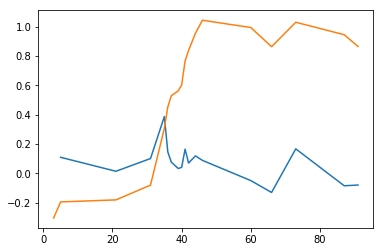

In [68]:
import math 
feature = 'Hours per week'
thresholds = [t for t in list(xgtests[feature].keys())]
thresholds.sort()
coefs = np.zeros(len(thresholds) + 1, dtype=float)
for i in range(len(thresholds)):
    for threshold in thresholds:
        if thresholds[i] <= threshold:
            coefs[i] += xgtests[feature][threshold][0]
        else:
            coefs[i] += xgtests[feature][threshold][1]
            
for threshold in thresholds:
    coefs[len(thresholds)] += xgtests[feature][threshold][1]
    
for i in range(1, len(coefs)):
    coefs[i] -= coefs[0]
coefs[0] = 0.0
diffs = np.zeros(len(thresholds))
diffs[0] = coefs[0]
for i in range(len(thresholds)):
    diffs[i] = coefs[i + 1] - coefs[i]
    
plt.plot(thresholds[1:], diffs[1:])
plt.plot(thresholds, coefs[1:])

In [76]:
selected = {}
weird = {}

for feature, thresholds in xgtests_c.items():
    ts = list(thresholds)
    ts.sort()
    if len(ts) > 1:
        if feature in ['Capital Gain', 'Capital Loss']:
            weird[feature] = np.zeros(len(X), dtype=bool)
            keep = []
            for i in range(len(ts)):
                lb = float('-inf') if i == 0 else ts[i - 1]
                ub = ts[i]
                mask = X[feature].between(lb, ub)
                if y[mask].any() or True:
                    keep = keep + [ub]
                else:
                    weird[feature] |= mask
            selected[feature] = set(keep)
        else:
            selected[feature] = set(ts)
    else:
        selected[feature] = set(ts)
        
selected = boost_predicates(boost)
selected

{'Age': {19,
  21,
  22,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  60,
  61,
  62,
  65,
  67,
  68,
  71,
  72,
  73,
  76,
  77,
  80,
  82,
  86,
  87},
 'Capital Gain': {58,
  3049,
  3121,
  4226,
  4244,
  4402,
  4669,
  4719,
  4827,
  4933,
  4974,
  5096,
  5120,
  5317,
  5910,
  6458,
  6619,
  7056,
  7074,
  7437,
  7566,
  8297,
  10544,
  10586,
  11142,
  12615,
  21046,
  30962,
  70655},
 'Capital Loss': {78,
  732,
  1447,
  1458,
  1495,
  1525,
  1538,
  1552,
  1569,
  1578,
  1749,
  1783,
  1806,
  1821,
  1847,
  1860,
  1882,
  1895,
  1928,
  1976,
  1979,
  2155,
  2169,
  2177,
  2191,
  2193,
  2219,
  2235,
  2253,
  2263,
  2311,
  2365,
  2366,
  2385,
  2425,
  2451,
  2470,
  2519,
  2582,
  2790,
  3090,
  3727},
 'Country_Cambodia': {1},
 'Country_Canada': {1},
 'Country_China': {1},
 'Country_Colum

In [77]:
X_proj = {}

non_smooth = ['Capital Gain', 'Capital Loss']

for feature, thresholds in selected.items():
    thresholds = list(thresholds)
    thresholds.sort()
    if len(thresholds) > 1:
        if feature in non_smooth:
            for i in range(len(thresholds) - 1):
                key = feature + ("_%02d_%.1f_%.1f" % (i, thresholds[i], thresholds[i+1]))
                mask = (X[feature] >= thresholds[i]) & (X[feature] < thresholds[i+1])
                X_proj[key] = mask
            key = feature + ("_%02d_%.1f<" % (len(thresholds) - 1, thresholds[-1]))
            X_proj[key] = X[feature] >= thresholds[-1]
        else:
            for i in range(len(thresholds)):
                key = feature + ("_%02d_%.1f" % (i, thresholds[i]))
                mask = X[feature] >= thresholds[i]
                X_proj[key] = mask
    else:
        X_proj[feature] = X[feature] >= thresholds[0]
        
X_proj = pd.DataFrame(X_proj)
# X_proj = X_proj[X_proj.columns.difference(rem)]
# X_proj

In [79]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

iterations = 20
scores_train = np.zeros(iterations, dtype=float)
scores_test = np.zeros(iterations, dtype=float)
y_proj = y
for i in range(iterations):
    X_proj_train, X_proj_test, y_train, y_test = train_test_split(X_proj, y_proj, train_size = 0.9)
    logrel = LogisticRegression(C = 1, solver = 'sag').fit(X_proj_train, y_train)
    # logrel = SGDClassifier(loss = 'log').fit(X_proj_train, y_train)
    scores_train[i] = logrel.score(X_proj_train, y_train)
    scores_test[i] = logrel.score(X_proj_test, y_test)
    print('Train', i, scores_train[i])
    print('Test', i, scores_test[i])

print('Train mean', scores_train.mean())
print('Train deviation', scores_train.std())
print('Test mean', scores_test.mean())
print('Test deviation', scores_test.std())

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/arthur/env/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Train 0 0.8756512045863003
Test 0 0.8722620266120777
Train 1 0.8754464590395159
Test 1 0.8700102354145343
Train 2 0.8754919580499124
Test 2 0.8732855680655066
Train 3 0.8755147075551106
Test 3 0.8698055271238485
Train 4 0.8751052164615419
Test 4 0.8800409416581372
Train 5 0.8757877016174899
Test 5 0.8673490276356193
Train 6 0.8762654412266533
Test 6 0.8630501535312181
Train 7 0.8751734649771368
Test 7 0.8747185261003071
Train 8 0.8756057055759037
Test 8 0.8751279426816786
Train 9 0.8758104511226881
Test 9 0.8714431934493347
Train 10 0.8749459699251542
Test 10 0.8775844421699078
Train 11 0.8748777214095593
Test 11 0.8716479017400205
Train 12 0.8749004709147576
Test 12 0.8745138178096213
Train 13 0.8756967035966968
Test 13 0.8685772773797339
Train 14 0.8749004709147576
Test 14 0.8755373592630502
Train 15 0.8750369679459472
Test 15 0.876560900716479
Train 16 0.8753782105239211
Test 16 0.8730808597748209


KeyboardInterrupt: 

In [73]:
logrel.intercept_

array([-10.83258869])

In [74]:
coefs_lin = dict(zip(X_proj.columns, list(logrel.coef_[0])))
coefs_lin

{'Age_00_21.0': 0.9536778679551058,
 'Age_01_22.0': -0.030618046815487587,
 'Age_02_24.0': 0.4690988068218225,
 'Age_03_25.0': 0.5010323334735309,
 'Age_04_26.0': 0.16039292927839996,
 'Age_05_27.0': 0.12447726985285495,
 'Age_06_28.0': 0.22660351598742132,
 'Age_07_29.0': 0.10350544786639695,
 'Age_08_30.0': 0.3171061522819666,
 'Age_09_34.0': 0.20483885607633687,
 'Age_10_36.0': 0.0791685402899735,
 'Age_11_37.0': 0.1687368143398594,
 'Age_12_39.0': 0.026815637504301583,
 'Age_13_43.0': 0.08452846790046004,
 'Age_14_44.0': 0.030990017361350587,
 'Age_15_45.0': 0.03876446834287838,
 'Age_16_46.0': 0.15769672340757535,
 'Age_17_55.0': -0.16776053367780977,
 'Age_18_60.0': -0.0985479569652332,
 'Age_19_62.0': -0.1453871142586664,
 'Age_20_67.0': -0.2079421146988884,
 'Age_21_74.0': 0.26840421158082134,
 'Age_22_82.0': -0.7870399425320926,
 'Capital Gain_00_58.0_3049.0': -6.568387024026094,
 'Capital Gain_01_3049.0_3121.0': 3.2548319480210797,
 'Capital Gain_02_3121.0_4244.0': -7.2668830

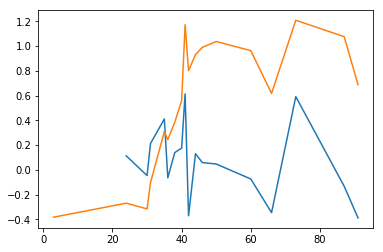

In [75]:
feature = 'Hours per week'

thresholds = list(selected[feature])
thresholds.sort()

if feature in non_smooth:
    vals = [coefs_lin[feature + ("_%02d_%.1f_%.1f" % (i, thresholds[i], thresholds[i+1]))]
            for i in range(len(thresholds) - 1)]
    vals = vals + [coefs_lin[feature + ("_%02d_%.1f<" % (len(thresholds)-1, thresholds[-1]))]]
    plt.plot(thresholds, vals)
else:
    diffs1 = np.array([coefs_lin[feature + ("_%02d_%.1f" % (i, thresholds[i]))] for i in range(len(thresholds))])
    vals   = np.array([sum(diffs1[:i + 1]) for i in range(len(thresholds))])
 
    plt.plot(thresholds[1:], diffs1[1:])
    plt.plot(thresholds, vals)   

In [24]:
thresholds[0:0]

[]

In [45]:
ps = original
sel = ps[feature] <= thresholds[0]
print('High', thresholds[0], 'Size', sum(sel), y[sel].mean())
for i in range(len(thresholds) - 1):
    a = thresholds[i]
    b = thresholds[i + 1]
    sel = ps[feature].between(a, b)
    print('Low', a, 'High', b, 'Size', sum(sel), y[sel].mean())
sel = ps[feature] >= thresholds[-1]
print('Low', thresholds[-1], 'Size', sum(sel), y[sel].mean())

High 57.0 Size 44807 0.20523578905081796
Low 57.0 High 3048.0 Size 701 0.0
Low 3048.0 High 3120.0 Size 152 0.9342105263157895
Low 3120.0 High 4243.5 Size 435 0.0
Low 4243.5 High 4401.0 Size 108 0.8518518518518519
Low 4401.0 High 4668.5 Size 110 0.0
Low 4668.5 High 4826.0 Size 39 1.0
Low 4826.0 High 4973.5 Size 39 0.2564102564102564
Low 4973.5 High 5119.0 Size 119 0.0
Low 5119.0 High 5316.5 Size 146 1.0
Low 5316.5 High 6667.5 Size 78 0.44871794871794873
Low 6667.5 High 7055.5 Size 53 0.0
Low 7055.5 High 7565.5 Size 387 0.9819121447028424
Low 7565.5 High 8296.0 Size 416 0.9927884615384616
Low 8296.0 High 10585.5 Size 190 0.9578947368421052
Low 10585.5 High 70654.5 Size 818 0.9877750611246944
Low 70654.5 Size 244 1.0


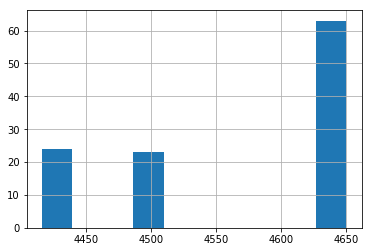

In [47]:
original['Capital Gain'][X['Capital Gain'].between(4401, 4668)].hist()

In [4]:
# We work with data points in a transformed space of tree paths.
# Given a point, we compute the vector of leaf nodes that the point
# reached on each tree, under a one-hot encoding.
# Each leaf corresponds uniquely to a path traversed in the tree.

leaves = boost.apply(X).reshape(len(X), n_estimators)
leaf_encoder = OneHotEncoder().fit(leaves)
leaf_encoder.transform(leaves)

<48842x2813 sparse matrix of type '<class 'numpy.float64'>'
	with 19536800 stored elements in Compressed Sparse Row format>

In [22]:
# We can cluster these points using the scores assigned by each
# tree in the model, running PCA first to reduce the dimension.

n_clusters = 7
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

X_enc = np.array([boost.estimators_[k, 0].predict(X) for k in range(boost.n_estimators)]).transpose()
X_pca = TruncatedSVD(n_components = 10).fit_transform(X_enc)
X_enc = X_pca # Comment this line to disable PCA
clustering = KMeans(n_clusters = n_clusters).fit(X_pca)
clusters = clustering.predict(X_pca)

<Figure size 480x480 with 0 Axes>

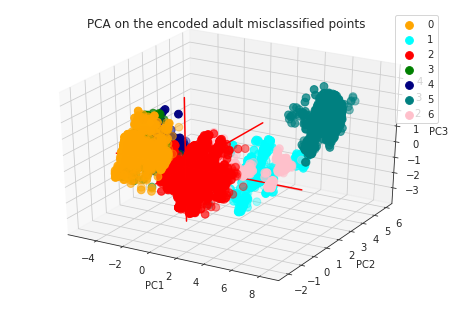

In [23]:
# Here is the result of running PCA on the encoded points

my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set_style('white')
 
# Store results of PCA in a data frame
result=pd.DataFrame(X_pca[:,range(3)], columns=['PCA%i' % i for i in range(3)])
 
# Plot initialisation
fig = plt.figure()
ax = Axes3D(fig)

colors = ['orange', 'cyan', 'red', 'green', 'navy', 'teal', 'pink', 'yellow', 'purple', 'black']

for k, c in zip(range(n_clusters), colors):
    ax.scatter(result['PCA0'][clusters == k],
               result['PCA1'][clusters == k],
               result['PCA2'][clusters == k],
               c=c, cmap="Set2_r", s=60, label=k)

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the encoded adult misclassified points")
ax.legend()
#plt.show()

In [24]:
from display_cluster import display_cluster

def encode_features(original):
    return X.loc[original.index]

display_cluster(boost, original, original, y, 
                leaves.astype(int),
                clusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Winner,Mean Winner Prob.
0,8330,0.904442,False,0.904775
1,5198,0.723355,True,0.647975
2,14942,0.759001,False,0.713229
3,9426,0.986845,False,0.982160
4,7813,0.997568,False,0.996368
5,2200,0.990455,True,0.980476
6,933,0.976420,True,0.958502


interactive(children=(BoundedIntText(value=0, description='Cluster', max=7), Dropdown(description='Column', op…

In [25]:
from display_cluster import InfluentialPaths
paths = InfluentialPaths(boost, leaves.astype(int), X, clusters, n_clusters)

In [26]:
def refine_interval(i, direction, threshold):
    if i == ():
        return ()
    if direction == 'left':
        return (i[0], min(threshold, i[1])) if threshold > i[0] else ()
    # direction == 'right'
    return (max(threshold, i[0]), i[1]) if threshold < i[1] else ()

def summarize_cluster(k, n_paths):
    s = {}
    for rank in range(n_paths):
        forest_path = paths[k, rank]
        for node, feature, threshold, direction in forest_path.path:
            if direction != None:
                i = s[feature] if feature in s else (float('-inf'), float('inf'))
                s[feature] = refine_interval(i, direction, threshold)
    return s

def summary_mask(s, X):
    mask = pd.Series(np.ones(len(X), dtype=bool))
    for feature, i in s.items():
        if i == ():
            return pd.Series(np.zeros(len(X), dtype=bool))
        mask = mask & X[feature].between(i[0], i[1])
    return mask

k = 4
n_paths = 3

s = summarize_cluster(k, n_paths)


In [37]:
lengths = [1, 1, 1, 5, 5, 1, 1, 5, 9, 3]
ss = [summarize_cluster(i, l) for i, l in zip(range(n_clusters), lengths)]
ts = [summary_mask(s, X) for s in ss]
for k, s, t in zip(range(n_clusters), ss, ts):
    print(k)    
    m = t
    mk = clusters == k
    mmk = m & mk
    print('Summary size', sum(m))
    print('Cluster size', sum(mk))
    print('Overlap size', sum(m & mk))
    print('Cluster to summary %.3f' % (sum(m & mk) / sum(mk)))
    print('Summary to cluster %.3f' % (sum(m & mk) / sum(m)))
    display(s)

0
Summary size 24905
Cluster size 8330
Overlap size 7605
Cluster to summary 0.913
Summary to cluster 0.305


{'Capital Gain': (-inf, 7055.5),
 'Education-Num': (-inf, 13.5),
 'Relationship_Spouse': (-inf, 0.5)}

1
Summary size 5611
Cluster size 5198
Overlap size 5069
Cluster to summary 0.975
Summary to cluster 0.903


{'Capital Gain': (-inf, 5095.5),
 'Education-Num': (12.5, inf),
 'Relationship_Spouse': (0.5, inf)}

2
Summary size 11028
Cluster size 14942
Overlap size 5123
Cluster to summary 0.343
Summary to cluster 0.465


{'Capital Gain': (-inf, 5095.5),
 'Education-Num': (9.5, inf),
 'Relationship_Spouse': (0.5, inf)}

3
Summary size 17436
Cluster size 9426
Overlap size 7458
Cluster to summary 0.791
Summary to cluster 0.428


{'Capital Gain': (-inf, 4668.5),
 'Capital Loss': (-inf, 2218.5),
 'Education-Num': (-inf, 12.5),
 'Hours per week': (-inf, 42.5),
 'Relationship_Spouse': (-inf, 0.5)}

4
Summary size 7065
Cluster size 7813
Overlap size 6953
Cluster to summary 0.890
Summary to cluster 0.984


{'Age': (-inf, 24.5),
 'Capital Gain': (-inf, 7055.5),
 'Education-Num': (-inf, 12.5),
 'Relationship_Spouse': (-inf, 0.5)}

5
Summary size 1007
Cluster size 2200
Overlap size 995
Cluster to summary 0.452
Summary to cluster 0.988


{'Capital Gain': (5095.5, inf),
 'Education-Num': (12.5, inf),
 'Relationship_Spouse': (0.5, inf)}

6
Summary size 1123
Cluster size 933
Overlap size 933
Cluster to summary 1.000
Summary to cluster 0.831


{'Capital Gain': (-inf, 5095.5),
 'Capital Loss': (1782.5, inf),
 'Relationship_Spouse': (0.5, inf)}

In [38]:
X_red = pd.DataFrame({k: ts[k] for k in range(len(ts))})
(len(ts[0]), sum(ts[0] | ts[1] | ts[2] | ts[3] | ts[4])) #  | ts[5] | ts[6] | ts[7] | ts[8] | ts[9]))

(48842, 35933)

In [39]:
from sklearn.linear_model import LogisticRegression 
iterations = 20
scores = np.zeros(iterations, dtype=float)
for i in range(iterations):
    X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y, train_size = 0.9)
    forest_red = LogisticRegression().fit(X_red_train, y_red_train)
    scores[i] = forest_red.score(X_red_test, y_red_test)
    
print('Test mean', scores.mean())

/home/arthur/env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Test mean 0.825926305015353


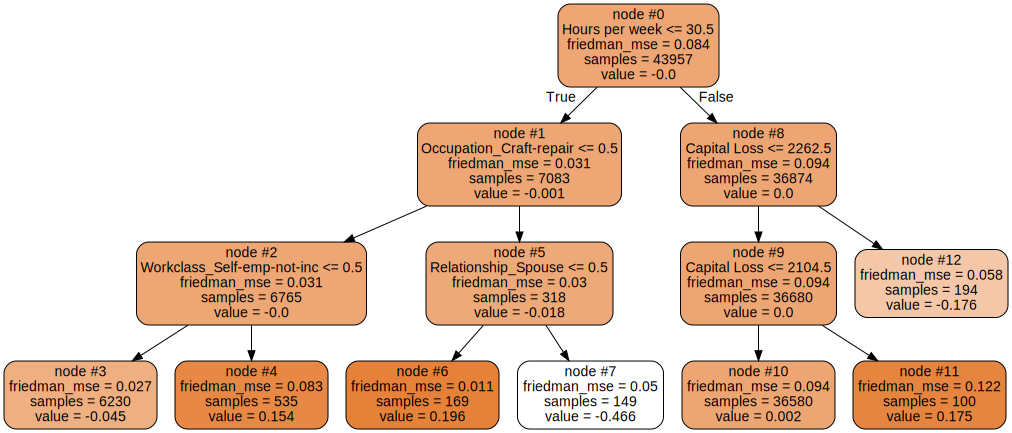

In [188]:
# The paths tends to have a lot of redundancy in terms
# of classification behavior

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(boost.estimators_[799, 0],
                           feature_names = X_test.columns,
                           out_file = None, filled = True,
                           rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
graph

In [58]:
# Greedy path clustering

from display_cluster import InfluentialPaths

mclusters = np.zeros(len(X))
leaves = boost.apply(X).reshape((len(X), boost.n_estimators)).astype(int)
r = np.ones(len(X), dtype=bool)
n_clusters = 5

for k in range(n_clusters - 1):
    paths = InfluentialPaths(boost, leaves[r], X[r], np.zeros(sum(r)), 1)
    p = paths[0, 0]
    c = leaves[:,p.tree] == p.first_node
    t = np.logical_and(r, c)
    r = np.logical_and(r, c == False)
    mclusters = mclusters + k * t
    
mclusters = mclusters + (n_clusters - 1) * r

In [66]:
print(sum((mclusters == 2) & (clusters == 1)))
print(sum((mclusters == 0) & (clusters == 2)))
print(sum((mclusters == 1) & (clusters == 4)))
print(sum((mclusters == 3) & (clusters == 3)))
print(sum((mclusters == 0) & (clusters == 0)))

14518
17756
5610
758
8565


In [59]:
display_cluster(boost, original, original, y, 
                leaves, mclusters, n_clusters,
                encode_features=encode_features)

,Size,Accuracy,Winner,Mean Winner Prob.
0,26324,0.954870,False,0.949735
1,6618,0.777576,True,0.734103
2,14671,0.757004,False,0.707212
3,758,0.980211,True,0.948918
4,471,0.963907,True,0.964443


interactive(children=(BoundedIntText(value=0, description='Cluster', max=5), Dropdown(description='Column', op…

Text(0.5,0.92,'PCA on the encoded adult misclassified points')

<Figure size 480x480 with 0 Axes>

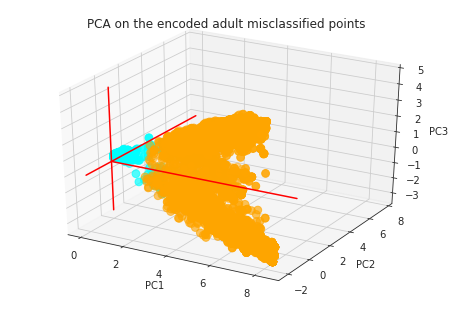

In [12]:
leaves_pca = TruncatedSVD(n_components = 3).fit_transform(cleaf_encoder.transform(leaves[r == False]))
mclusters_first = mclusters[r == False]
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set_style('white')
df = pd.DataFrame(leaves_pca)
 
# Store results of PCA in a data frame
result=pd.DataFrame(leaves_pca, columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure()
ax = Axes3D(fig)

colors = ['orange', 'cyan', 'red', 'green', 'navy']

for k, c in zip(range(n_clusters - 1), colors):
    ax.scatter(result['PCA0'][mclusters_first == k], result['PCA1'][mclusters_first == k], result['PCA2'][mclusters_first == k], c=c, cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the encoded adult misclassified points")
#plt.show()

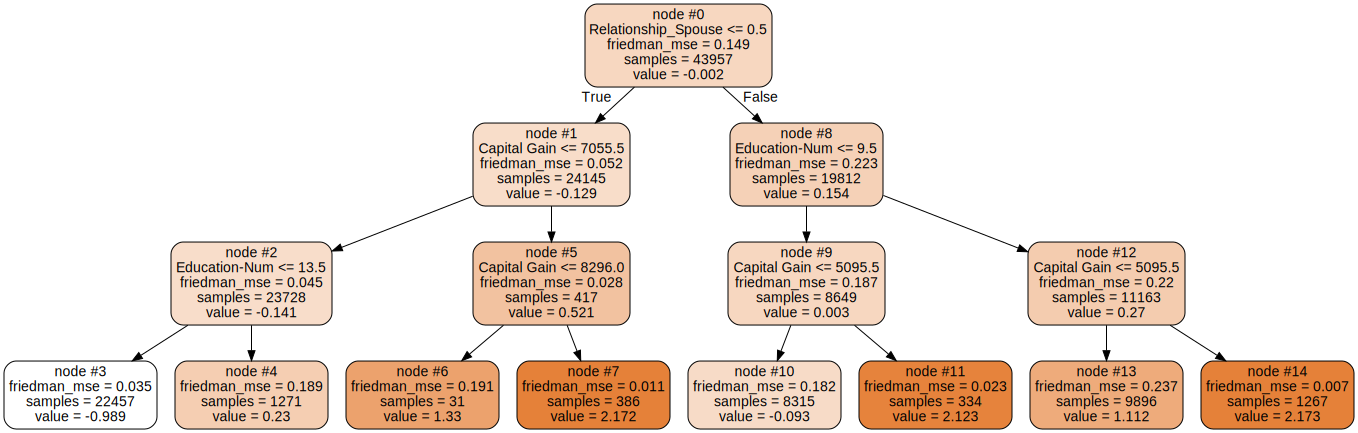

In [34]:
# The paths tends to have a lot of redundancy in terms
# of classification behavior

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(boost.estimators_[3][0],
                           feature_names = X_test.columns,
                           out_file = None, filled = True,
                           rounded = True, node_ids = True)
graph = graphviz.Source(dot_data)
graph